In [1]:
# !pip install fake-useragent
# !pip install selenium

# if you want to use webdriver on google colab, please install the following package

# !apt-get update # to update ubuntu to correctly run apt install
# !apt install chromium-chromedriver
# !cp /usr/lib/chromium-browser/chromedriver /usr/bin
import fake_useragent
from selenium import webdriver

print( fake_useragent.VERSION )

0.1.11


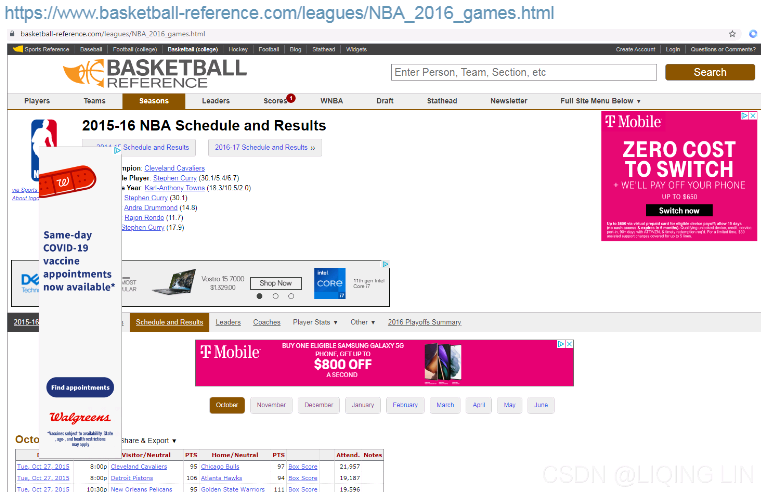

Use Selenium to locate the drop-down menu that appears when the mouse is hovered And write the xpath conditional expression in separate lines：
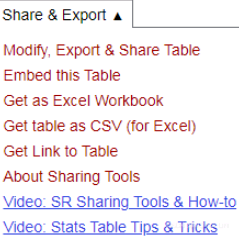

# Collecting the data

In [ ]:
ua = fake_useragent.UserAgent() # .random

ua_list = [ua.ie, ua['Internet Explorer'], ua.msie,
           ua.chrome, ua.google, ua['google chrome'],
           ua.firefox, ua.ff,
           ua.safari, 
           ua.opera
          ]

import random
current_ua = random.choice(ua_list)
header = {'UserAgent': current_ua,
          'Connection': 'close'
         }
options = webdriver.ChromeOptions()
options.add_argument( "'" + "user-agent=" + header['UserAgent'] + "'" )
options.add_argument('--disable-gpu') # google document mentioned this attribute can avoid some bugs
# the purpose of the argument --disable-gpu was to enable google-chrome-headless on windows platform. 
# It was needed as SwiftShader fails an assert on Windows in headless mode ### earlier.###
# it doesn't run the script without opening the browser,but this bug ### was fixed.###
# options.add_argument('--headless') is all you need.
 
# The browser does not provide a visualization page. 
# If the system does not support visualization under linux, it will fail to start if you do not add this one
# options.add_argument('--headless')
 
# Solve the prompt that chrome is being controlled by the automatic test software
options.add_experimental_option('excludeSwitches',['enable-automation'])

options.add_experimental_option('useAutomationExtension', False)


# set the browser as developer model, prevent the website identifying that you are using Selenium
driver = webdriver.Chrome( executable_path = 'C:/chromedriver/chromedriver', # last chromedriver is chromedriver.exe
                            options = options
                          )
# #run command("window.navigator.webdriver")in the Console of the inspection
# #result: undefine  # means: regular browser

driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", 
                        {
                          "source": """
                                    delete navigator.__proto__.webdriver;
                                    """
                        }
                       )

 
driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", 
                        {
                          "source": """
                                    Object.defineProperty( navigator, 
                                                           'webdriver', 
                                                           {
                                                             get: () => undefined
                                                           }
                                                )
                                    """
                        }
                       )
                       
                       
# browser.set_window_size(1920, 1080)

root = 'https://www.basketball-reference.com/leagues/'
page_link = 'NBA_2016_games.html#schedule'

url = root + page_link

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time
from selenium.webdriver.common.action_chains import ActionChains
import io 
import pandas as pd

wait = WebDriverWait(driver, 2)

time_0 = time.time()
driver.get( url )

# https://www.selenium.dev/selenium/docs/api/py/webdriver/selenium.webdriver.common.by.html#module-selenium.webdriver.common.by
wait.until( EC.presence_of_element_located(
                                            ( By.ID, 'content' ),
                                          )
          )

time_1 = time.time()
print(time_1-time_0,':\n',driver.current_url)


#import pandas as pd

# /html/body/div[2]/div[5]/div[3]/div[2]/table
# df = pd.read_html(driver.page_source)[0]
# print(df)

                                    # /html/body/div[2]/div[5]/div[2]/div[1]

month_div_list = driver.find_elements_by_xpath('//div[@id="content"]/div[@class="filter"]/div')
month_link_list = []
month_list = []

for m in month_div_list:
    page_link = m.find_element_by_xpath('./a').get_attribute('href')# .text # get_attribute('href')
    month_link_list.append(page_link)
    month_list.append( m.find_element_by_xpath('./a').text )
    
time_2 = time.time()    
print('Get all links:', time_2)
print( month_list )

def crawlData( month ):
    
    driver.get( month[0] )
    wait.until( EC.presence_of_element_located(
                                                ( By.ID, 'all_schedule' ),
                                              )
              )
    
    share_export='Get table as CSV (for Excel)'
    #                     //*[@id="schedule_sh"]/div/ul/li/div/ul/li[4]/button
    # /html/body/div[2]/div[5]/ div[3]/div[1]/   div/ul/li/div/ul/li[4]/button
    # <button class="tooltip" tip="Get a link directly to this table on this page" type="button">Get table as CSV (for Excel)</button>
    
    share_export_menu = driver.find_element_by_xpath('//div[@id="schedule_sh"]/div[@class="section_heading_text"]')
    hidden_submenu = driver.find_element_by_xpath('//div[@id="schedule_sh"]/div[@class="section_heading_text"]' \
                                                  '/ul/li/div/ul/li/button[contains(text(),"{}")]'.format(share_export)
                                                 )
    
    actions = ActionChains( driver )
    actions.move_to_element( share_export_menu )
    actions.click( hidden_submenu )
    actions.perform()
    
    
    wait.until( EC.presence_of_element_located(
                                                ( By.ID, 'div_schedule' ),
                                              )
              )
    csv = driver.find_element_by_xpath('//div[@id="div_schedule"]/div/pre[@id="csv_schedule"]').text
    


    df = pd.read_fwf( io.StringIO(csv) )
    df.to_csv( month[1] + '.csv', #'temp.csv', 
               header=False, index=False, sep='\n') # sep='\n'
    


    
time_3 = time.time()


from multiprocessing import Pool

pool = Pool(2) 
pool.map( crawlData,
       zip(month_link_list, month_list)
     )
pool.close()
pool.join()
    
driver.quit()
    
    

58.86636686325073 :
 https://www.basketball-reference.com/leagues/NBA_2016_games.html#schedule
Get all links: 1630198306.9659905
['October', 'November', 'December', 'January', 'February', 'March', 'April', 'May', 'June']


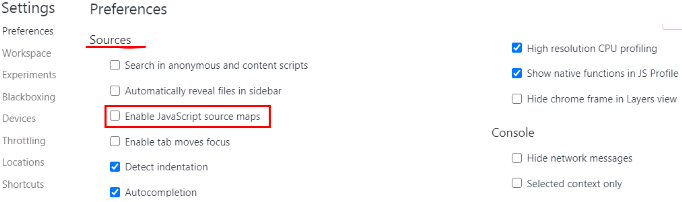

In [3]:
ua = fake_useragent.UserAgent() # .random

ua_list = [ua.ie, ua['Internet Explorer'], ua.msie,
           ua.chrome, ua.google, ua['google chrome'],
           ua.firefox, ua.ff,
           ua.safari, 
           ua.opera
          ]

import random
current_ua = random.choice(ua_list)
header = {'UserAgent': current_ua,
          'Connection': 'close'
         }
options = webdriver.ChromeOptions()
options.add_argument( "'" + "user-agent=" + header['UserAgent'] + "'" )
options.add_argument('--disable-gpu') # google document mentioned this attribute can avoid some bugs
# the purpose of the argument --disable-gpu was to enable google-chrome-headless on windows platform. 
# It was needed as SwiftShader fails an assert on Windows in headless mode ### earlier.###
# it doesn't run the script without opening the browser,but this bug ### was fixed.###
# options.add_argument('--headless') is all you need.
 
# The browser does not provide a visualization page. 
# If the system does not support visualization under linux, it will fail to start if you do not add this one
# options.add_argument('--headless')
 
# Solve the prompt that chrome is being controlled by the automatic test software
options.add_experimental_option('excludeSwitches',['enable-automation'])

options.add_experimental_option('useAutomationExtension', False)


# set the browser as developer model, prevent the website identifying that you are using Selenium
driver = webdriver.Chrome( executable_path = 'C:/chromedriver/chromedriver', # last chromedriver is chromedriver.exe
                            options = options
                          )
# #run command("window.navigator.webdriver")in the Console of the inspection
# #result: undefine  # means: regular browser

driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", 
                        {
                          "source": """
                                    delete navigator.__proto__.webdriver;
                                    """
                        }
                       )

 
driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", 
                        {
                          "source": """
                                    Object.defineProperty( navigator, 
                                                           'webdriver', 
                                                           {
                                                             get: () => undefined
                                                           }
                                                )
                                    """
                        }
                       )
                       
                       
# browser.set_window_size(1920, 1080)

root = 'https://www.basketball-reference.com/leagues/'
page_link = 'NBA_2016_games.html#schedule'

url = root + page_link

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time
from selenium.webdriver.common.action_chains import ActionChains
import io 
import pandas as pd

wait = WebDriverWait(driver, 2)

time_0 = time.time()
driver.get( url )

# https://www.selenium.dev/selenium/docs/api/py/webdriver/selenium.webdriver.common.by.html#module-selenium.webdriver.common.by
wait.until( EC.presence_of_element_located(
                                            ( By.ID, 'content' ),
                                          )
          )

time_1 = time.time()
print(time_1-time_0,':\n',driver.current_url)


#import pandas as pd

# /html/body/div[2]/div[5]/div[3]/div[2]/table
# df = pd.read_html(driver.page_source)[0]
# print(df)

                                    # /html/body/div[2]/div[5]/div[2]/div[1]

month_div_list = driver.find_elements_by_xpath('//div[@id="content"]/div[@class="filter"]/div')
month_link_list = []
month_list = []

for m in month_div_list:
    page_link = m.find_element_by_xpath('./a').get_attribute('href')# .text # get_attribute('href')
    month_link_list.append(page_link)
    month_list.append( m.find_element_by_xpath('./a').text )
    
time_2 = time.time()    
print('Get all links:', time_2)
# month_list

for page_month_index in range( len(month_list) ):
    
    time_3 = time.time()
    
    driver.get( month_link_list[page_month_index] )
    wait.until( EC.presence_of_element_located(
                                                ( By.ID, 'all_schedule' ),
                                              )
              )
    
    share_export='Get table as CSV (for Excel)'
    #                     //*[@id="schedule_sh"]/div/ul/li/div/ul/li[4]/button
    # /html/body/div[2]/div[5]/ div[3]/div[1]/   div/ul/li/div/ul/li[4]/button
    # <button class="tooltip" tip="Get a link directly to this table on this page" type="button">Get table as CSV (for Excel)</button>
    
    share_export_menu = driver.find_element_by_xpath('//div[@id="schedule_sh"]/div[@class="section_heading_text"]')
    hidden_submenu = driver.find_element_by_xpath('//div[@id="schedule_sh"]/div[@class="section_heading_text"]' \
                                                  '/ul/li/div/ul/li/button[contains(text(),"{}")]'.format(share_export)
                                                 )
    
    actions = ActionChains( driver )
    actions.move_to_element( share_export_menu )
    actions.click( hidden_submenu )
    actions.perform()
    
    
    wait.until( EC.presence_of_element_located(
                                                ( By.ID, 'div_schedule' ),
                                              )
              )
    csv = driver.find_element_by_xpath('//div[@id="div_schedule"]/div/pre[@id="csv_schedule"]').text
    

    # Process string format data, save it to csv file 
    df = pd.read_fwf( io.StringIO(csv) )
    df.to_csv( month_list[page_month_index] + '.csv', #'temp.csv', 
               header=False, index=False, sep='\n') # sep='\n'
    
    print(driver.current_url)
driver.quit()    

65.09072279930115 :
 https://www.basketball-reference.com/leagues/NBA_2016_games.html#schedule
Get all links: 1630452462.0516117
https://www.basketball-reference.com/leagues/NBA_2016_games-october.html
https://www.basketball-reference.com/leagues/NBA_2016_games-november.html
https://www.basketball-reference.com/leagues/NBA_2016_games-december.html
https://www.basketball-reference.com/leagues/NBA_2016_games-january.html
https://www.basketball-reference.com/leagues/NBA_2016_games-february.html
https://www.basketball-reference.com/leagues/NBA_2016_games-march.html
https://www.basketball-reference.com/leagues/NBA_2016_games-april.html
https://www.basketball-reference.com/leagues/NBA_2016_games-may.html
https://www.basketball-reference.com/leagues/NBA_2016_games-june.html


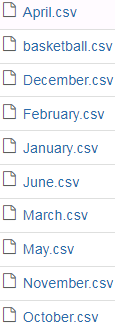

# Combine the data in all CSV files and store them in a file and named it with ‘basketball.csv’

delete "Mexico" in December.csv and then save it
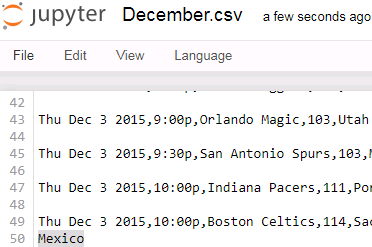

In [5]:
df_whole = pd.read_csv( month_list[0] + '.csv',  sep=',', dtype={ 'PTS': 'int',
                                                                  'PTS.1': 'int',
                                                                  'Attend.': 'int',
                                                                  'Notes': "string",
                                                                  'Unnamed: 7': 'object',
                                                                }, 
                        )

for m in range( 1, len(month_list) ):
    cur_m_df = pd.read_csv( month_list[m] + '.csv',  sep=',', dtype={ 'PTS': 'int',
                                                                      'PTS.1': 'int',
                                                                      'Attend.': 'int',
                                                                      'Notes': "string",
                                                                      'Unnamed: 7': 'object',
                                                                    }, 
                          )
    df_whole = pd.merge( df_whole, cur_m_df, how='outer' )

df_whole.shape  

(1316, 10)

In [6]:
df_whole.to_csv('basketball.csv', index=False)

# load the dataset using the read_csv function

In [52]:
import pandas as pd

data_filename='basketball.csv'
dataset = pd.read_csv(data_filename)

dataset.head()

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes
0,Tue Oct 27 2015,8:00p,Cleveland Cavaliers,95,Chicago Bulls,97,Box Score,NaN,21957,NaN
1,Tue Oct 27 2015,8:00p,Detroit Pistons,106,Atlanta Hawks,94,Box Score,NaN,19187,NaN
2,Tue Oct 27 2015,10:30p,New Orleans Pelicans,95,Golden State Warriors,111,Box Score,NaN,19596,NaN
3,Wed Oct 28 2015,7:00p,Washington Wizards,88,Orlando Magic,87,Box Score,NaN,18846,NaN
4,Wed Oct 28 2015,7:30p,Philadelphia 76ers,95,Boston Celtics,112,Box Score,NaN,18624,NaN


# After looking at the output, we can see a number of problems:

* The date is just a string and not a date object
* From visually inspecting the results, the headings aren't complete or correct

In [53]:
dataset = pd.read_csv( data_filename, parse_dates=['Date'] )

dataset.columns = ["Date", "Start (ET)", "Visitor Team", "VisitorPts", "Home Team", 
                   "HomePts", "OT?", "Score Type","Attend.", "Notes"]
dataset.head()

,Date,Start (ET),Visitor Team,VisitorPts,Home Team,HomePts,OT?,Score Type,Attend.,Notes
0,2015-10-27,8:00p,Cleveland Cavaliers,95,Chicago Bulls,97,Box Score,NaN,21957,NaN
1,2015-10-27,8:00p,Detroit Pistons,106,Atlanta Hawks,94,Box Score,NaN,19187,NaN
2,2015-10-27,10:30p,New Orleans Pelicans,95,Golden State Warriors,111,Box Score,NaN,19596,NaN
3,2015-10-28,7:00p,Washington Wizards,88,Orlando Magic,87,Box Score,NaN,18846,NaN
4,2015-10-28,7:30p,Philadelphia 76ers,95,Boston Celtics,112,Box Score,NaN,18624,NaN


In [54]:
dataset = dataset.drop('Attend.', axis=1)
dataset.head()

,Date,Start (ET),Visitor Team,VisitorPts,Home Team,HomePts,OT?,Score Type,Notes
0,2015-10-27,8:00p,Cleveland Cavaliers,95,Chicago Bulls,97,Box Score,NaN,NaN
1,2015-10-27,8:00p,Detroit Pistons,106,Atlanta Hawks,94,Box Score,NaN,NaN
2,2015-10-27,10:30p,New Orleans Pelicans,95,Golden State Warriors,111,Box Score,NaN,NaN
3,2015-10-28,7:00p,Washington Wizards,88,Orlando Magic,87,Box Score,NaN,NaN
4,2015-10-28,7:30p,Philadelphia 76ers,95,Boston Celtics,112,Box Score,NaN,NaN


In [55]:
print(dataset.dtypes)

Date            datetime64[ns]
Start (ET)              object
Visitor Team            object
VisitorPts               int64
Home Team               object
HomePts                  int64
OT?                     object
Score Type              object
Notes                   object
dtype: object


# Extracting new features

In [56]:
# specify our class as 1(True) if the home team wins and 0(False) if the visitor team wins
dataset["HomeWin"] = dataset["VisitorPts"] < dataset["HomePts"]
dataset.head()

,Date,Start (ET),Visitor Team,VisitorPts,Home Team,HomePts,OT?,Score Type,Notes,HomeWin
0,2015-10-27,8:00p,Cleveland Cavaliers,95,Chicago Bulls,97,Box Score,NaN,NaN,True
1,2015-10-27,8:00p,Detroit Pistons,106,Atlanta Hawks,94,Box Score,NaN,NaN,False
2,2015-10-27,10:30p,New Orleans Pelicans,95,Golden State Warriors,111,Box Score,NaN,NaN,True
3,2015-10-28,7:00p,Washington Wizards,88,Orlando Magic,87,Box Score,NaN,NaN,False
4,2015-10-28,7:30p,Philadelphia 76ers,95,Boston Celtics,112,Box Score,NaN,NaN,True


In [57]:
y_true = dataset["HomeWin"].values

In [58]:
# show the advantage on home team
dataset['HomeWin'].mean()

0.5942249240121581

In [59]:
from collections import defaultdict

won_last = defaultdict(int)
won_last

defaultdict(int, {})

In [60]:
dataset["HomeLastWin"] = 0
dataset["VisitorLastWin"] = 0
dataset.head()

,Date,Start (ET),Visitor Team,VisitorPts,Home Team,HomePts,OT?,Score Type,Notes,HomeWin,HomeLastWin,VisitorLastWin
0,2015-10-27,8:00p,Cleveland Cavaliers,95,Chicago Bulls,97,Box Score,NaN,NaN,True,0,0
1,2015-10-27,8:00p,Detroit Pistons,106,Atlanta Hawks,94,Box Score,NaN,NaN,False,0,0
2,2015-10-27,10:30p,New Orleans Pelicans,95,Golden State Warriors,111,Box Score,NaN,NaN,True,0,0
3,2015-10-28,7:00p,Washington Wizards,88,Orlando Magic,87,Box Score,NaN,NaN,False,0,0
4,2015-10-28,7:30p,Philadelphia 76ers,95,Boston Celtics,112,Box Score,NaN,NaN,True,0,0


In [61]:
for row_index, row in dataset.iterrows(): #  (row_index, The data of the row as a Series), ..., ...    
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    
    row["HomeLastWin"] = won_last[home_team] # won_last[home_team] : whether the home team won the previous game
    
    dataset.at[ row_index, "HomeLastWin" ] = won_last[home_team]
    dataset.at[ row_index, "VisitorLastWin" ] = won_last[visitor_team]
    
    won_last[home_team] = int( row["HomeWin"] )
    won_last[visitor_team] = 1-int( row["HomeWin"] )

dataset.head(n=10)    

,Date,Start (ET),Visitor Team,VisitorPts,Home Team,HomePts,OT?,Score Type,Notes,HomeWin,HomeLastWin,VisitorLastWin
0,2015-10-27,8:00p,Cleveland Cavaliers,95,Chicago Bulls,97,Box Score,NaN,NaN,True,0,0
1,2015-10-27,8:00p,Detroit Pistons,106,Atlanta Hawks,94,Box Score,NaN,NaN,False,0,0
2,2015-10-27,10:30p,New Orleans Pelicans,95,Golden State Warriors,111,Box Score,NaN,NaN,True,0,0
3,2015-10-28,7:00p,Washington Wizards,88,Orlando Magic,87,Box Score,NaN,NaN,False,0,0
4,2015-10-28,7:30p,Philadelphia 76ers,95,Boston Celtics,112,Box Score,NaN,NaN,True,0,0
5,2015-10-28,7:30p,Chicago Bulls,115,Brooklyn Nets,100,Box Score,NaN,NaN,False,0,1
6,2015-10-28,7:30p,Utah Jazz,87,Detroit Pistons,92,Box Score,NaN,NaN,True,1,0
7,2015-10-28,7:30p,Indiana Pacers,99,Toronto Raptors,106,Box Score,NaN,NaN,True,0,0
8,2015-10-28,7:30p,Charlotte Hornets,94,Miami Heat,104,Box Score,NaN,NaN,True,0,0
9,2015-10-28,8:00p,New York Knicks,122,Milwaukee Bucks,97,Box Score,NaN,NaN,False,0,0


In [62]:
dataset.iloc[1000:1005]

,Date,Start (ET),Visitor Team,VisitorPts,Home Team,HomePts,OT?,Score Type,Notes,HomeWin,HomeLastWin,VisitorLastWin
1000,2016-03-15,8:30p,Los Angeles Clippers,87,San Antonio Spurs,108,Box Score,NaN,NaN,True,1,0
1001,2016-03-15,10:30p,Sacramento Kings,106,Los Angeles Lakers,98,Box Score,NaN,NaN,False,0,0
1002,2016-03-16,7:00p,Oklahoma City Thunder,130,Boston Celtics,109,Box Score,NaN,NaN,False,0,1
1003,2016-03-16,7:00p,Orlando Magic,99,Charlotte Hornets,107,Box Score,NaN,NaN,True,0,1
1004,2016-03-16,7:00p,Dallas Mavericks,98,Cleveland Cavaliers,99,Box Score,NaN,NaN,True,0,1


In [63]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier( random_state=14 ) #  default=”gini”

In [64]:
X_previous_wins = dataset[ ["HomeLastWin", "VisitorLastWin"] ].values
X_previous_wins

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [1, 0],
       [1, 0],
       [0, 1]], dtype=int64)

In [65]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Accuracy = (TP+TN)/(TP+FP+FN+TN)
#                         to use the default 5-fold cross validation
scores = cross_val_score( clf, X_previous_wins, y_true, scoring='accuracy' )
print( "Accuracy: {0:.1f}%".format( np.mean(scores)*100 ) )

Accuracy: 59.4%


# Sports outcome prediction

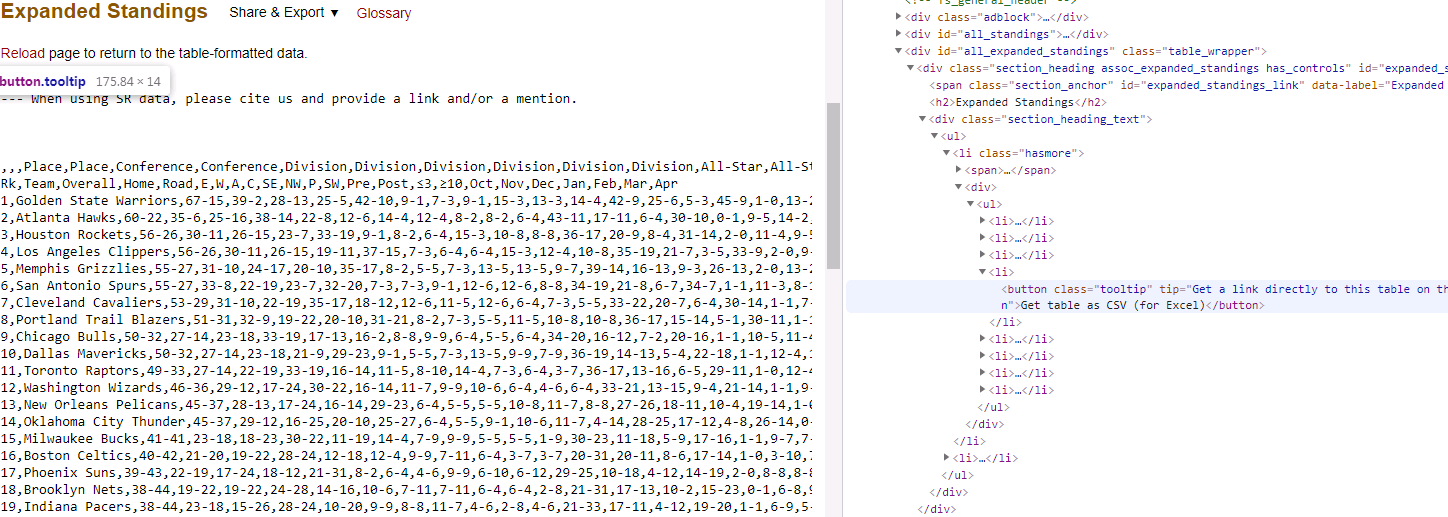

In [66]:
ua = fake_useragent.UserAgent() # .random

ua_list = [ua.ie, ua['Internet Explorer'], ua.msie,
           ua.chrome, ua.google, ua['google chrome'],
           ua.firefox, ua.ff,
           ua.safari, 
           ua.opera
          ]

import random
current_ua = random.choice(ua_list)
header = {'UserAgent': current_ua,
          'Connection': 'close'
         }
options = webdriver.ChromeOptions()
options.add_argument( "'" + "user-agent=" + header['UserAgent'] + "'" )
options.add_argument('--disable-gpu') # google document mentioned this attribute can avoid some bugs
# the purpose of the argument --disable-gpu was to enable google-chrome-headless on windows platform. 
# It was needed as SwiftShader fails an assert on Windows in headless mode ### earlier.###
# it doesn't run the script without opening the browser,but this bug ### was fixed.###
# options.add_argument('--headless') is all you need.
 
# The browser does not provide a visualization page. 
# If the system does not support visualization under linux, it will fail to start if you do not add this one
# options.add_argument('--headless')
 
# Solve the prompt that chrome is being controlled by the automatic test software
options.add_experimental_option('excludeSwitches',['enable-automation'])

options.add_experimental_option('useAutomationExtension', False)


# set the browser as developer model, prevent the website identifying that you are using Selenium
driver = webdriver.Chrome( executable_path = 'C:/chromedriver/chromedriver', # last chromedriver is chromedriver.exe
                            options = options
                          )
# #run command("window.navigator.webdriver")in the Console of the inspection
# #result: undefine  # means: regular browser

driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", 
                        {
                          "source": """
                                    delete navigator.__proto__.webdriver;
                                    """
                        }
                       )

 
driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", 
                        {
                          "source": """
                                    Object.defineProperty( navigator, 
                                                           'webdriver', 
                                                           {
                                                             get: () => undefined
                                                           }
                                                )
                                    """
                        }
                       )
                       
                       
# browser.set_window_size(1920, 1080)

root = 'https://www.basketball-reference.com/leagues/'
page_link = 'NBA_2015_standings.html'

url = root + page_link

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time
from selenium.webdriver.common.action_chains import ActionChains
import io 
import pandas as pd

wait = WebDriverWait(driver, 2)

driver.get( url )

# https://www.selenium.dev/selenium/docs/api/py/webdriver/selenium.webdriver.common.by.html#module-selenium.webdriver.common.by
wait.until( EC.presence_of_element_located(
                                            ( By.ID, 'all_expanded_standings' ),
                                          )
          )
    
share_export='Get table as CSV (for Excel)'
    #                     //*[@id="schedule_sh"]/div/ul/li/div/ul/li[4]/button
    # /html/body/div[2]/div[5]/ div[3]/div[1]/   div/ul/li/div/ul/li[4]/button
    # <button class="tooltip" tip="Get a link directly to this table on this page" type="button">Get table as CSV (for Excel)</button>
    
share_export_menu = driver.find_element_by_xpath('//div[@id="expanded_standings_sh"]/div[@class="section_heading_text"]')
hidden_submenu = driver.find_element_by_xpath('//div[@id="expanded_standings_sh"]/div[@class="section_heading_text"]' \
                                                  '/ul/li/div/ul/li/button[contains(text(),"{}")]'.format(share_export)
                                                 )
    
actions = ActionChains( driver )
actions.move_to_element( share_export_menu )
actions.click( hidden_submenu )
actions.perform()
    
    
wait.until( EC.presence_of_element_located(
                                            ( By.ID, 'div_expanded_standings' ),
                                          )
          )
csv = driver.find_element_by_xpath('//div[@id="div_expanded_standings"]/div/pre[@id="csv_expanded_standings"]').text
    
standings_fileName="standings.csv"

df = pd.read_fwf( io.StringIO(csv) )
df.to_csv( standings_fileName, #'temp.csv', 
        header=False, index=False, sep='\n') # sep='\n'
      
print(driver.current_url)

    
driver.quit()
    

https://www.basketball-reference.com/leagues/NBA_2015_standings.html


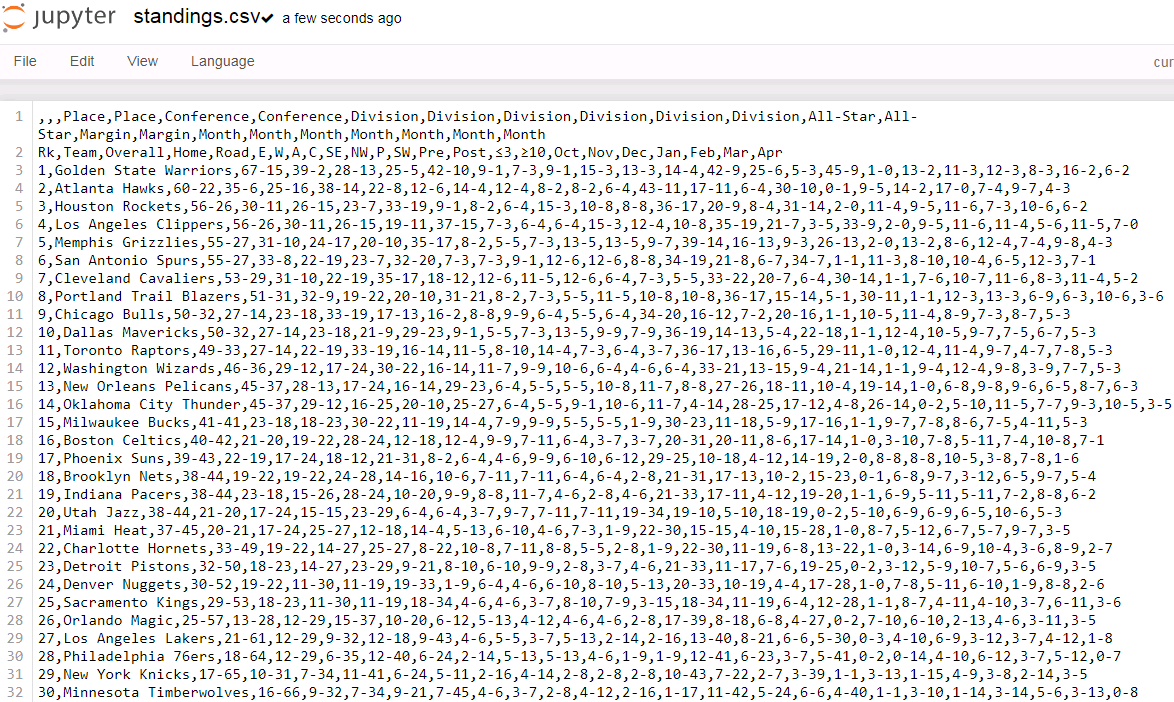

In [67]:
import os

standings = pd.read_csv( "standings.csv", skiprows=1 )
standings.head()

,Rk,Team,Overall,Home,Road,E,W,A,C,SE,...,Post,≤3,≥10,Oct,Nov,Dec,Jan,Feb,Mar,Apr
0,1,Golden State Warriors,67-15,39-2,28-13,25-5,42-10,9-1,7-3,9-1,...,25-6,5-3,45-9,1-0,13-2,11-3,12-3,8-3,16-2,6-2
1,2,Atlanta Hawks,60-22,35-6,25-16,38-14,22-8,12-6,14-4,12-4,...,17-11,6-4,30-10,0-1,9-5,14-2,17-0,7-4,9-7,4-3
2,3,Houston Rockets,56-26,30-11,26-15,23-7,33-19,9-1,8-2,6-4,...,20-9,8-4,31-14,2-0,11-4,9-5,11-6,7-3,10-6,6-2
3,4,Los Angeles Clippers,56-26,30-11,26-15,19-11,37-15,7-3,6-4,6-4,...,21-7,3-5,33-9,2-0,9-5,11-6,11-4,5-6,11-5,7-0
4,5,Memphis Grizzlies,55-27,31-10,24-17,20-10,35-17,8-2,5-5,7-3,...,16-13,9-3,26-13,2-0,13-2,8-6,12-4,7-4,9-8,4-3


In [68]:
dataset["HomeTeamRanksHigher"] = 0

for index, row in dataset.sort_values(by="Date").iterrows():
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    
    home_rank = standings[ standings["Team"] == home_team ]["Rk"].values[0]
    visitor_rank = standings[ standings["Team"] == visitor_team ]["Rk"].values[0]
    dataset.at[index, "HomeTeamRanksHigher"] = int( home_rank < visitor_rank )
    
dataset.head(n=10)    

,Date,Start (ET),Visitor Team,VisitorPts,Home Team,HomePts,OT?,Score Type,Notes,HomeWin,HomeLastWin,VisitorLastWin,HomeTeamRanksHigher
0,2015-10-27,8:00p,Cleveland Cavaliers,95,Chicago Bulls,97,Box Score,NaN,NaN,True,0,0,0
1,2015-10-27,8:00p,Detroit Pistons,106,Atlanta Hawks,94,Box Score,NaN,NaN,False,0,0,1
2,2015-10-27,10:30p,New Orleans Pelicans,95,Golden State Warriors,111,Box Score,NaN,NaN,True,0,0,1
3,2015-10-28,7:00p,Washington Wizards,88,Orlando Magic,87,Box Score,NaN,NaN,False,0,0,0
4,2015-10-28,7:30p,Philadelphia 76ers,95,Boston Celtics,112,Box Score,NaN,NaN,True,0,0,1
5,2015-10-28,7:30p,Chicago Bulls,115,Brooklyn Nets,100,Box Score,NaN,NaN,False,0,1,0
6,2015-10-28,7:30p,Utah Jazz,87,Detroit Pistons,92,Box Score,NaN,NaN,True,1,0,0
7,2015-10-28,7:30p,Indiana Pacers,99,Toronto Raptors,106,Box Score,NaN,NaN,True,0,0,1
8,2015-10-28,7:30p,Charlotte Hornets,94,Miami Heat,104,Box Score,NaN,NaN,True,0,0,1
9,2015-10-28,8:00p,New York Knicks,122,Milwaukee Bucks,97,Box Score,NaN,NaN,False,0,0,1


In [69]:
X_homehigher = dataset[ ["HomeTeamRanksHigher", "HomeLastWin", "VisitorLastWin"] ].values
X_homehigher

array([[0, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 1, 0],
       [0, 1, 0],
       [1, 0, 1]], dtype=int64)

In [70]:
clf = DecisionTreeClassifier( random_state=14 , criterion='entropy' ) #  default=”gini”

scores = cross_val_score( clf, X_homehigher, y_true, scoring="accuracy" )

print( "Accuracy: {0:.1f}%".format( np.mean(scores)*100 ) )

Accuracy: 61.8%


This now scores 61.8 percent even better than our previous result, and now better than just using wheather the teams were winner on previous game to do predictions on every time. Can we do better?

In [71]:
last_match_winner = defaultdict( int )
dataset["HomeTeamWonLast"] = 0

for index, row in dataset.iterrows():
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    
    teams = tuple( sorted( [home_team, visitor_team] ) )
    
    # We look up in our dictionary to see who won the last encounter between 
    # the two teams. Then, we update the row in the dataset data frame:
    if last_match_winner[teams] : # == row["Home Team"]
        home_team_won_last = 1
    else: 
        home_team_won_last = 0
    
    dataset.at[index, "HomeTeamWonLast"] = home_team_won_last
    
    # Who won this match?
    if row["HomeWin"]:
        winner = row["Home Team"]
    else:
        winner = row["Visitor Team"]
    
    last_match_winner[teams] = winner

This feature works much like our previous rank-based feature. However, instead of looking up the ranks, this features creates a tuple called teams, and then stores the previous result in a dictionary( last_match_winner = defaultdict( int ) ). When those two teams play each other next, it recreates this tuple, and looks up the previous result. Our code doesn't differentiate between home games and visitor games, which might be a useful improvement to look at implementing. 

In [102]:
dataset.iloc[15:20]

,Date,Start (ET),Visitor Team,VisitorPts,Home Team,HomePts,OT?,Score Type,Notes,HomeWin,HomeLastWin,VisitorLastWin,HomeTeamRanksHigher,HomeTeamWonLast
15,2015-10-28,10:00p,Los Angeles Clippers,111,Sacramento Kings,104,Box Score,NaN,NaN,False,0,0,0,0
16,2015-10-28,10:30p,Minnesota Timberwolves,112,Los Angeles Lakers,111,Box Score,NaN,NaN,False,0,0,1,0
17,2015-10-29,7:00p,Memphis Grizzlies,112,Indiana Pacers,103,Box Score,NaN,NaN,False,0,0,0,0
18,2015-10-29,8:00p,Atlanta Hawks,112,New York Knicks,101,Box Score,NaN,NaN,False,1,0,0,0
19,2015-10-29,10:30p,Dallas Mavericks,88,Los Angeles Clippers,104,Box Score,NaN,NaN,True,1,1,1,0


Memphis Grizzlies (Visitor) won the 17th match against Indiana Pacers (home)

In [103]:
dataset.iloc[345:405]

,Date,Start (ET),Visitor Team,VisitorPts,Home Team,HomePts,OT?,Score Type,Notes,HomeWin,HomeLastWin,VisitorLastWin,HomeTeamRanksHigher,HomeTeamWonLast
345,2015-12-12,7:30p,Indiana Pacers,96,Detroit Pistons,118,Box Score,NaN,NaN,True,1,1,0,0
346,2015-12-12,8:00p,San Antonio Spurs,103,Atlanta Hawks,78,Box Score,NaN,NaN,False,0,1,1,0
347,2015-12-12,8:00p,New Orleans Pelicans,94,Chicago Bulls,98,Box Score,NaN,NaN,True,1,1,1,0
348,2015-12-12,8:00p,Los Angeles Lakers,97,Houston Rockets,126,Box Score,NaN,NaN,True,1,0,1,0
349,2015-12-12,8:30p,Washington Wizards,114,Dallas Mavericks,111,Box Score,NaN,NaN,False,0,0,1,1
350,2015-12-12,8:30p,Golden State Warriors,95,Milwaukee Bucks,108,Box Score,NaN,NaN,True,0,1,0,0
351,2015-12-12,10:00p,New York Knicks,112,Portland Trail Blazers,110,Box Score,NaN,NaN,False,1,0,1,0
352,2015-12-13,3:30p,Minnesota Timberwolves,101,Phoenix Suns,108,Box Score,NaN,NaN,True,0,0,1,0
353,2015-12-13,6:00p,Memphis Grizzlies,97,Miami Heat,100,Box Score,NaN,NaN,True,0,0,0,0
354,2015-12-13,6:00p,Philadelphia 76ers,76,Toronto Raptors,96,Box Score,NaN,NaN,True,1,0,1,1


Houston Rockets (home) won the 348th match against Los Angeles Lakers (Visitor), so the 384th Houston Rockets (Visitor) and Los Angeles Lakers (home) record (HomeTeamWonLast) value is 0.

Indiana Pacers lost in the 17th matchup against Memphis Grizzlies, so in the 401st Memphis Grizzlies(home) and Indiana Pacers (visitor) record (HomeTeamWonLast) value is 1.

In [104]:
X_lastwinner = dataset[ ["HomeTeamWonLast",# The result of the last match between the two teams
                         "HomeTeamRanksHigher", 
                         "HomeLastWin",    # Results of the last match against other teams
                         "VisitorLastWin", # Results of the last match against other teams
                        ] ]
# the Gini index and the cross-entropy are quite similar numerically
clf = DecisionTreeClassifier( random_state=14, criterion="entropy" )
scores = cross_val_score( clf, X_lastwinner, y_true, scoring = "accuracy")

print( "Accuracy: {0:.1f}%".format( np.mean(scores)*100) )

Accuracy: 62.4%


While decision trees are capable of learning from categorical features, the implementation in scikit-learn requires those features to be encoded as numbers and features, instead of string values. We can use the LabelEncoder transformer to convert the string-based team names into assigned integer values. The code is as follows:

In [130]:
from sklearn.preprocessing import LabelEncoder

encoding = LabelEncoder()
encoding.fit( dataset["Home Team"].values )

home_teams = encoding.transform( dataset["Home Team"].values )
visitor_teams = encoding.transform( dataset["Visitor Team"].values )

X_teams = np.vstack( [home_teams,   # [ 4,  0,  9, ...,  9,  5,  9]
                      visitor_teams # [ 5,  8, 18, ...,  5,  9,  5]
                     ] 
                   ).T
X_teams

array([[ 4,  5],
       [ 0,  8],
       [ 9, 18],
       ...,
       [ 9,  5],
       [ 5,  9],
       [ 9,  5]])

These integers can be fed into the Decision Tree, but they will still be interpreted as continuous features by DecisionTreeClassifier. For example, teams may be allocated integers from 0 to 16. *The algorithm will see teams 1 and 2 as being similar, while teams 4 and 10 will be very different*--but this makes no sense as all. All of the teams are different from each other--two teams are either the same or they are not!

using OneHotEncoder

In [136]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder()
X_teams = onehot.fit_transform( X_teams ).todense()

X_teams[-3:]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

[9,5]: Represents the combination of Cleveland Cavaliers (as a visitor team, encoded 9) and Golden State Warriors (as a home team, encoded 5) as a category for OneHotEncoder encoding, and its encoding value is not same with [5,9], Golden State Warriors (as a visitor team, encoded 5) and Cleveland Cavaliers (as a home team, encoded 9) as a new combination, the encoding value of OneHotEncoder is different

In [137]:
dataset[-3:]

,Date,Start (ET),Visitor Team,VisitorPts,Home Team,HomePts,OT?,Score Type,Notes,HomeWin,HomeLastWin,VisitorLastWin,HomeTeamRanksHigher,HomeTeamWonLast
1313,2016-06-13,9:00p,Cleveland Cavaliers,112,Golden State Warriors,97,Box Score,NaN,NaN,False,1,0,1,1
1314,2016-06-16,9:00p,Golden State Warriors,101,Cleveland Cavaliers,115,Box Score,NaN,NaN,True,1,0,0,1
1315,2016-06-19,8:00p,Cleveland Cavaliers,93,Golden State Warriors,89,Box Score,NaN,NaN,False,0,1,1,0


In [138]:
clf = DecisionTreeClassifier( random_state=14 )
scores = cross_val_score( clf, X_teams, y_true, scoring='accuracy') # default cv=5

print( 'Accuracy: {0:.1f}%'.format(np.mean(scores)*100) )

Accuracy: 63.7%


In [141]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier( random_state=14) # default criterion='gini', n_estimators=100
score = cross_val_score( clf, X_teams, y_true, scoring="accuracy" )# default cv=5

print( "Accuracy: {0:.1f}%".format( np.mean(scores)*100 ) )

Accuracy: 63.7%


In [142]:
X_all = np.hstack( [X_lastwinner, X_teams] )
clf = RandomForestClassifier( random_state=14 ) # default criterion='gini', n_estimators=100
scores = cross_val_score( clf, X_all, y_true, scoring="accuracy" )

print( "Accuracy: {0:.1f}%".format(np.mean(scores)*100) )

Accuracy: 64.4%


In [144]:
X_all = np.hstack( [X_lastwinner, X_teams] )
clf = RandomForestClassifier( random_state=14, n_estimators=500 ) # default criterion='gini', n_estimators=100
scores = cross_val_score( clf, X_all, y_true, scoring="accuracy" )

print( "Accuracy: {0:.1f}%".format(np.mean(scores)*100) )

Accuracy: 64.6%


In [146]:
from sklearn.model_selection import GridSearchCV

parameter_space = {
    "max_features":[2,10,'auto'],
    "n_estimators":[100,200],
    "criterion":["gini","entropy"],
    "min_samples_leaf":[2,4,6]
}

clf = RandomForestClassifier( random_state=14 )
grid = GridSearchCV( clf, parameter_space )
grid.fit( X_all, y_true )

print( "Accuracy: {0:.1f}%".format(grid.best_score_*100) )

Accuracy: 67.7%


we can print out the best model that was found in the grid search. The code is as follows

In [147]:
print( grid.best_estimator_ )

RandomForestClassifier(criterion='entropy', min_samples_leaf=4,
                       n_estimators=200, random_state=14)
